## 0. Trim Data
kann optional einaml ausgeführt werden um einen Datensatz "trimmed_globalterrorismdb.csv" zu erstellen, welcher auf Github hochgeladen werden kann. Dieser ist jedoch schon im PULL-Umfang enthalten.

Feature: Bad Runtime O(n* n!) -> could be optimized Binary Split

In [37]:
import pandas as pd
from IPython.display import display, clear_output

colums_to_use = [
    "eventid",
    "iday",
    "imonth",
    "iyear",
    "longitude",
    "latitude",
    "country",
    "country_txt",
    "nkill",
    "weaptype1",
    "weaptype1_txt",
    "targtype1",
    "gname",
    "claimed"
]

max_storage_size = 25*pow(10,6)                                 #max upload size for GitHub

original_df = pd.read_csv("globalterrorismdb.csv", usecols=colums_to_use, low_memory=False)

trimmed_df = pd.DataFrame(columns=colums_to_use)

if original_df.memory_usage().sum() < max_storage_size:
    trimmed_df = original_df

else:
    reversed_df = original_df.iloc[::-1].reset_index(drop=True)     #reverse df to keep the newest entries

    for i, row in original_df.iterrows():
        clear_output(wait=True)
        display(f"{round(i / len(original_df) * 100, 2)} %")

        if trimmed_df.memory_usage().sum() + row.memory_usage() > max_storage_size:
            break                                               #break if max upload size is reached
        else:
            trimmed_df.loc[i] = row

    trimmed_df = trimmed_df.iloc[::-1].reset_index(drop=True)   #reverse back to original order

print(f"Original File Size: {original_df.memory_usage().sum() / pow(10,6)}")
print(f"Trimmed  File Size: {trimmed_df.memory_usage().sum() / pow(10,6)}")

trimmed_df.to_csv("trimmed_globalterrorismdb.csv")

Original File Size: 20.349524
Trimmed  File Size: 20.349524


# 1 Data Understanding

## 1.1 Read Data

In [38]:
import pandas as pd
df = pd.read_csv("trimmed_globalterrorismdb.csv", low_memory=False)

## 1.2 Clean Data

In [39]:
#Create datetime colum for further use. Set day to 01.01 if unknown
df["datetime"] = df.apply(lambda x: pd.to_datetime("{}/{}/{}".format(x["iday"] or 1, x["imonth"] or 1, x["iyear"]), dayfirst=True, utc=True), axis=1)

#Shorten "Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)" of row weaptype1_txt to "Vehicle"
df["weaptype1_txt"] = df["weaptype1_txt"].replace('Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Vehicle')

#Create unique int keys for gname
df["gname_txt"] = df["gname"]
df["gname"] = df['gname'].map({value: idx for idx, value in enumerate(df['gname'].unique())})

## 1.3 Analize Data

In [40]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   Unnamed: 0     181691 non-null  int64              
 1   eventid        181691 non-null  int64              
 2   iyear          181691 non-null  int64              
 3   imonth         181691 non-null  int64              
 4   iday           181691 non-null  int64              
 5   country        181691 non-null  int64              
 6   country_txt    181691 non-null  object             
 7   latitude       177135 non-null  float64            
 8   longitude      177134 non-null  float64            
 9   targtype1      181691 non-null  int64              
 10  gname          181691 non-null  int64              
 11  claimed        115571 non-null  float64            
 12  weaptype1      181691 non-null  int64              
 13  weaptype1_txt  181691 non-nul

# 2 Dynamic Filters

In [41]:
apply_all_filter = False # <- Change bool to activate all filter

apply_filter_countries = apply_all_filter or True # <- Change bool to filter countries
apply_filter_years = apply_all_filter or False # <- Change bool to filter years

filter_countries = [
    #Intresting
    "United States",
    "East Germany (GDR)",
    "West Germany (FRG)",
    "United Kingdom",

    #Amerika
    "Mexico",
    "Nicaragua",
    "Peru",
    "Columbia"

    #Afrika
    "Nigeria",
    "Uganda",
    "Algeria",
    "West Bank and Gaza Strip",

    #Asia
    "Philippines",
    "Sri Lanka",
    "Afghanistan",
    "Bangladesh"
]
filter_years = list(range(1970, 2001))

if apply_filter_countries:
    df = df[df['country_txt'].isin(filter_countries)]
if apply_filter_years:
    df = df[df['iyear'].isin(filter_years)]

# 3 Auswertung

## 3.1 Charts

### 3.1.1 Line Chart - Visulize History

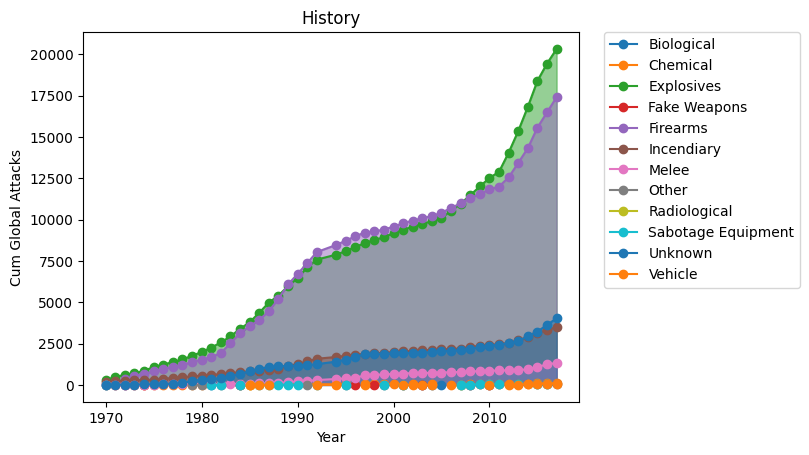

In [42]:
import matplotlib.pyplot as plt

df_history_weaptype1 = df.groupby(["iyear", "weaptype1_txt"]).size().groupby(level=1).cumsum().unstack()

plt_history_weaptype1 = df_history_weaptype1.plot(kind="line", marker="o")

for line in plt_history_weaptype1.lines:    
    color = line.get_color()    
    plt_history_weaptype1.fill_between(df_history_weaptype1.index, df_history_weaptype1[line.get_label()], color=color, alpha=0.5)

plt_history_weaptype1.set_title("History")
plt_history_weaptype1.set_xlabel("Year")
plt_history_weaptype1.set_ylabel("Cum Global Attacks")
plt_history_weaptype1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)

plt.show()

### 2.1.2 Stacked Bar Chart - 

## 3.2 Correlation

### 3.2.1 Correlation Table

<Axes: >

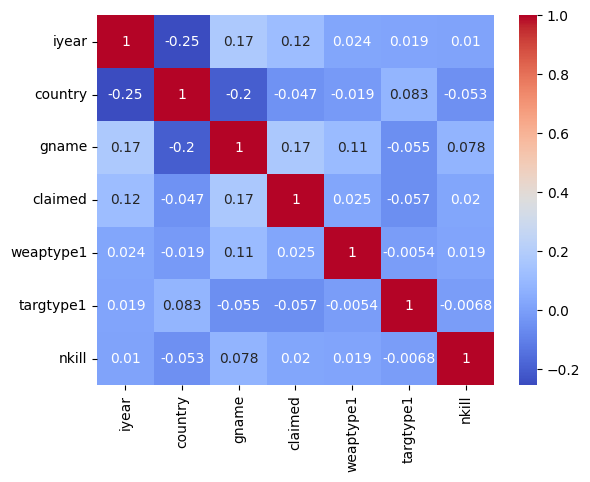

In [45]:
import seaborn as sns

df_correlation = df.loc[:, ["iyear", "country", "gname", "claimed", "weaptype1", "targtype1", "nkill"]]
df_correlation.dropna(inplace=True)

sns.heatmap(df_correlation.corr(), cmap='coolwarm', annot=True)

### 3.2.2 Visual Cluster

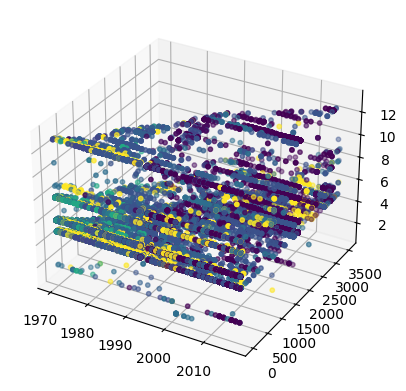

In [ ]:
import numpy as np

df_cluster = df

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_cluster["iyear"], df_cluster["gname"], df_cluster["weaptype1"], marker=".", c=df_cluster["country"], s=40)

plt.show()

## 3.3 Geo-Mapping
Visulize Attacks based on coordinates with corresponding fatalities and weapons

In [ ]:
import json
from keplergl import KeplerGl

df_nkills_weaptype1 = df
df_nkills_weaptype1.dropna(subset=["longitude", "latitude"], inplace=True)
df_nkills_weaptype1["height"] = (df_nkills_weaptype1["nkill"].fillna(0) + 1) * 100 #scale can be adjusted
df_nkills_weaptype1["weaptype1_txt"] = df_nkills_weaptype1["weaptype1_txt"].fillna("Unknown")

map_nkills_weaptype1 = KeplerGl()
map_nkills_weaptype1.add_data(data=df_nkills_weaptype1, name='df_nkills_weaptype1')

with open("map_nkills_weaptype1_config.json", "r") as f:
    map_nkills_weaptype1.config = json.load(f)

map_nkills_weaptype1
#print(json.dumps(map_nkills_weaptype1.config, indent=4))

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\ZODWEISS\AppData\Roaming\Python\Python311\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '9dw62hh', 'type': …